### Postać rozwiązania

Nasze rozwiązanie będzie miało postać wektorów wierzchołków grafu ułożonych w kolejności odwiedzania przypisanych do poszczególnych dronów:<br>

<center>
$d_{1}=(1,3,5...)$<br>
$d_{2}=(2,7,9...)$<br>
&emsp;&emsp;.<br>
&emsp;&emsp;.<br>
&emsp;&emsp;.<br>
$d_{M}=(10,15,4...)$<br>
   </center>
M - ilość wymaganych dronów

### Funkcja celu

\begin{equation*}
F=min (\sum \limits _{v=1} ^{M} \sum \limits _{i=0} ^{N} \sum \limits _{j=0} ^{N} c_{ij} x_{vij} + \alpha (M-D))
\end{equation*}

gdzie:
<ul>
    <li>$M$ – liczba dronów
    <li>$N$ – liczba odbiorców
    <li>$c_{ij}$ – koszt(czas) przejazdu od odbiorcy $i$ do odbiorcy $j$
    <li>$x_vij$ – zmienna decyzyjna która określa czy dron $v$ wykonuje trase od $i$ do $j$
    <li>$x_{vij} = \left\{
            \begin{array}{ll}
                1 & \mbox{gdy realizowany jest kurs od i do j przez drona v}\\
                0 & \mbox{w przeciwnym przypadku}
            \end{array}
        \right. 
        $
    <li>$\alpha$ – Współczynnik kary
    <li>$D$ – Liczba dronów w posiadaniu 
</ul>                  

### Ograniczenia
Jeśli $ x_{vij} = 1 \Rightarrow  u_{i} + q_{vj} = u_{j}$</br>

<center>$ q_{vi} \leq u_{i} \leq Q \quad \forall_{i} \in_{1, 2,..., N} $</center>

<!-- \begin{equation*}
\sum \limits _{v=1} ^{M} \sum \limits _{i=0} ^{N} y_{iv} \leq Q
\end{equation*}
\begin{equation*}
\sum \limits _{i=0} ^{N} y_{iv} \leq Q \quad }
\end{equation*}
 -->
$ q_{vi} $ – wielkość zapotrzebowania dostarczana do $i$-tego klienta przez $v$-tego drona

$Q $ – ładowność drona


### Struktury danych potrzebnych do algorytmu

> Macierz dystansów od poszczególnych odbiorców

\begin{equation*}
M_{i,j} = 
\begin{pmatrix}
d_{1,1} & d_{1,2} & \cdots & d_{1,n} \\
d_{2,1} & d_{2,2} & \cdots & d_{2,n} \\
\vdots  & \vdots  & \ddots & \vdots  \\
d_{i,1} & d_{i,2} & \cdots & d_{i,j} 
\end{pmatrix}
\end{equation*}

gdzie:
<ul>
    <li>$i, j$ - identyfikatory poszczególnych odbiorców</li>
    <li>$d_{i,j}$ - dystans pomiędzy odbiorcami $i, j$</li>
    <li>dystans - odległość euklidesowa $d_{i,j} = \sqrt{(x_{i}-x_{j})^{2}+(y_{i}-y_{j})^{2}}$
</ul>

> Lista położenia poszczególnych odbiorców

<center>$ L_{i} = a_{1}, a_{2},... a_{i} $</center>

gdzie:
<ul>
    <li>$a_{i}$ - koordynaty $i - tego$ odbiorcy $(x_{i}, y_{i})$</li>
</ul>


> Ilość dronów - M

> Ładowność drona - Q

> Ilość odbiorców - N




In [75]:
from functools import wraps
from time import time

def with_timer(func):
    """Print function runtime"""
    wraps(func)
    def f(*args, **kwargs):
        before = time()
        rv = func(*args, **kwargs)
        after = time()
        print('Elapsed time', after - before, 's')
        return rv
    return f

In [126]:
import numpy as np
import random
from matplotlib import pyplot as plt
import copy
import itertools
INF = 999999

class Client:
    """
    Odbiorca
        id: Identyfikator odbiorcy
        x, y: Koordynaty odbiorcy
    """
    def __init__(self, id, x, y):
        self.id = id
        self.x, self.y = x, y
        
    def __repr__(self):
        return f'Client {self.id} ({self.x}, {self.y})'
    
    def __eq__(self, other):
        return self.id == other.id
    
    def get_distance_from(self, point):
        return np.sqrt((point.x-self.x)**2 + (point.y-self.y)**2)

class Drone:
    """
    Dron
        id: Identyfikator drona
        x, y: Koordynaty drona
        velocity:  Prędkość drona 60km/h = 1km/min
        num_of_packages: Ilość paczek - Q
    """
    def __init__(self, id, capicity):
        self.id = id
        self.capicity = capicity
        self.num_of_packages = capicity
        self.temp_client_id = None
        self.x, self.y = 0, 0
        self.x_client, self.y_client = None, None
        self.x_prev_client, self.y_prev_client = None, None
        
    def __repr__(self):
        return '(Drone {}, Capicity: {})'.format(self.id, self.num_of_packages)
    
    def change_position(self, x, y):
        """
        Zmiana pozycji drona
        """
        self.x, self.y = x, y
    
    def get_distance_from_client(self):
        """
        Odległość euklidesowa
        """
        return np.sqrt((self.x_client-self.x)**2 + (self.y_client-self.y)**2)
    
    def deliver_package(self):
        """
        Dostarczanie paczki
        """
        self.num_of_packages -= 1
        self.x_prev_client = self.x_client
        self.y_prev_client = self.y_client
        if self.num_of_packages == 0:
            self.temp_client_id = None
            self.x_client = 0
            self.y_client = 0
        else:
            self.temp_client_id = None
            self.x_client = None
            self.y_client = None

    def load_packages(self):
        """ 
        Załadowanie drona
        """
        self.num_of_packages = self.capicity
    
    def specify_client(self, client):
        """
        Przypisanie klienta do drona
        """
        if self.temp_client_id == None:
            self.temp_client_id = client.id
            self.x_client = client.x
            self.y_client = client.y
    
    def travel(self):
        """
        Przemieszczanie się drona
        """
        if self.x_client is not None and self.y_client is not None:
            distance = self.get_distance_from_client()
            if (distance <= 1):
                if self.x_client == 0 and self.y_client == 0:
                    self.load_packages()
                self.x = self.x_client
                self.y = self.y_client
                self.deliver_package()
            else:
                w = abs(self.x - self.x_client)
                h = abs(self.y - self.y_client)
                sin_alpha = h/distance
                sin_beta = w/distance
                if (self.x >= self.x_client and self.y >= self.y_client):
                    self.change_position(self.x - sin_beta, self.y - sin_alpha)
                if (self.x <= self.x_client and self.y <= self.y_client):
                    self.change_position(self.x + sin_beta, self.y + sin_alpha)
                if (self.x >= self.x_client and self.y <= self.y_client):
                    self.change_position(self.x - sin_beta, self.y + sin_alpha)
                if (self.x <= self.x_client and self.y >= self.y_client):
                    self.change_position(self.x + sin_beta, self.y - sin_alpha)

class WithVisualisation:
    """
    Visualisation
        drones: Wszyskie dostępne drony. Ilość - M
        clients: Nieodwiedzeni odbiorcy
        x_visited, y_visited: Koordynaty odwiedzonych odbiorców
        total_time: Całkowity czas dostarczania paczek
    """
    ##############
    # Still some work to do..
    ##############
    def __init__(self, obj):
        self.drones = obj.drones
        self.clients = obj.clients
        self.solution = obj._best if obj._best else obj.generate_first_solution()
        self.total_time = 0
        self.threshold = 2000
        
        self.x_clients, self.y_clients = self._initialize_client_positions(obj.clients)
        self.x_visited, self.y_visited = [], []
        self.x_drones, self.y_drones = [], []
        self.path_colors = ['#ffe000', '#00ffb9', '#070208', '#9b00ff']
    
    @staticmethod
    def _initialize_client_positions(clients):
        """
        Inicjalizacja pozycji odbiorców do dronów
        """
        x_clients, y_clients = [], []
        for c in clients:
            x_clients.append(c.x)
            y_clients.append(c.y)
        return x_clients, y_clients
    
    def update_drone_positions(self):
        """
        Aktualizacja pozycji dronów
        """
        for drone in self.drones:
            self.x_drones.append(drone.x)
            self.y_drones.append(drone.y)
    
    def update_visited_clients(self, x, y):
        """
        Aktualizacja odwiedzonych odbiorców
        """
        self.x_visited.append(x)
        self.y_visited.append(y)
    
    def assign_clients(self):
        """
        Przipisanie odbiorców do wszystkich dronów
        """
        for drone in self.drones:
            if self.solution[drone]:
                drone.specify_client(self.solution[drone].pop(0))
    
    def assign_client(self, drone_id):
        """
        Przipisanie odbiorcy do jednego drona o przekazanym ID
        """
        for drone in self.drones:
            if drone.id == drone_id:
                if self.solution[drone]:
                    drone.specify_client(self.solution[drone].pop(0))
    
    def plot_figure(self):
        fig = plt.figure(figsize=(12,12))
    
    def visualize_solution(self):
        k = 1
        for i in range(self.threshold):
            k = 1 if k == 4 else k + 1
            for drone in self.drones:
                if drone.temp_client_id == None:
                    self.assign_client(drone.id)
                    self.update_visited_clients(drone.x_prev_client, drone.y_prev_client)
                drone.travel()
            self.update_drone_positions()
            plt.plot(self.x_clients, self.y_clients, 'go', markersize=12, label="Odbiorca")
            plt.plot(self.x_drones[-len(self.drones):], self.y_drones[-len(self.drones):], 'm{}'.format(k), markersize=20, label="Dron")
            for j in range(len(self.drones)):
                plt.plot(self.x_drones[j::len(self.drones)], self.y_drones[j::len(self.drones)], self.path_colors[j])
            plt.plot(self.x_visited, self.y_visited, 'ro', markersize=12, linewidth=4, label="Dostarczona paczka")
            plt.plot(0, 0, 'bo-', markersize=14)
            plt.grid()
            plt.ylim(-30, 30)
            plt.xlim(-30, 30)
            plt.title(f'Akutalny czas dostarczania paczek w minutach: {i+1}')
            plt.legend()
            plt.draw()
            plt.pause(0.05)
            plt.cla()
        plt.show()
    
    def plot_solution(self):
        for d in self.drones:
            if d in self.solution:
                x_s, y_s = zip(*[(point.x, point.y) for point in self.solution[d]]) 
                plt.plot(x_s, y_s, label=f'{d}')
        plt.plot(self.x_clients, self.y_clients, 'ro', markersize=12, label="Odbiorca")
        plt.plot(0, 0, 'bo', markersize=12, label="Baza")
        plt.grid()
        plt.legend()
        plt.ylim(-30, 30)
        plt.xlim(-30, 30)
        plt.show()

        
        
class TabuSearch:
    
    def __init__(self, num_of_drones=3, drone_capacity=4,
                 num_of_clients=12, clients_file=None):
        self.BASE = Client(0, 0, 0)
        self.M = num_of_drones # Actual number of drones
        self.Q = drone_capacity
        self.N = num_of_clients
        
        # D - number of routes needed to deliver packages
        self.drones, self.D = self._create_drones(num_of_clients, drone_capacity)
        self.clients = self._initialize_clients(clients_file, num_of_clients)
        self.distance_matrix = self._create_distance_matrix()
        
        self.tabu_list = []
        self.best_solution = None
        self.best_candidate = None
        self.candidate_cost = 0
        self.best_cost = 0
        self._best = {}
        self.costs = []
        self.best_costs = []
        
    def __repr__(self):
        return f'Tabu search for:\n\nClients: {self.clients}\n\nDrones: {self.drones}\n\nSolution: {self.solution}'
    
    @staticmethod
    def _create_drones(num_of_clients, drone_capacity):
        drones_needed = num_of_clients // drone_capacity
        if num_of_clients % drone_capacity == 0:
            drones = [Drone(i+1, drone_capacity) for i in range(drones_needed)]
        else:
            drones_needed += 1
            drones = [Drone(i+1, drone_capacity) for i in range(drones_needed)]
        return drones, drones_needed
    
    @staticmethod
    def _read_clients_from_file(file_name, num_of_clients):
        test_clients = np.loadtxt(file_name, delimiter=',', dtype=int)
        if len(test_clients) > num_of_clients:
            clients = [Client(*test_clients[i]) for i in range(num_of_clients)]
        else:
            clients = [Client(*c) for c in test_clients]
        return clients
    
    @staticmethod
    def _create_new_client_samples(file_name, num_of_clients):
        clients, busy = [], set()
        with open(file_name, 'w') as file:
            for i in range(num_of_clients):
                x_pos, y_pos = 0, 0
                while y_pos == 0 and x_pos == 0 and (x_pos, y_pos) not in busy:
                    x_pos = random.randint(-25,25)
                    y_pos = random.randint(-25,25)
                busy.add((x_pos, y_pos))
                file.write(f'{i+1},{x_pos},{y_pos}\n')
                clients.append(Client(i+1, x_pos, y_pos))
        return clients
    
    def _initialize_clients(self, file_name, num_of_clients):
        if file_name:
            try:
                clients = self._read_clients_from_file(file_name, num_of_clients)
            except OSError:
                return self._create_new_client_samples(file_name, num_of_clients)
            if len(clients) < self.N:
                raise Exception('Not enough samples in the file:\
                                change num_of_clients param passed to constructor.')
            return clients
        return self._create_new_client_samples("test_clients.txt", num_of_clients)
    
    def _create_distance_matrix(self):
        distance_matrix = np.zeros((self.N + 1, self.N + 1))
        for i in range(self.N + 1):
            for j in range(i, self.N + 1):
                if i != j:
                    if i == 0:
                        distance_matrix[i][j] = distance_matrix[j][i]\
                        = self.clients[j-1].get_distance_from(self.BASE)
                    else:
                        distance_matrix[i][j] = distance_matrix[j][i]\
                        = self.clients[i-1].get_distance_from(self.clients[j-1])
        return distance_matrix
    
    def find_next_drone_to_come_back(self, paths):
        lowest, idx = INF, 0
        for i, d in enumerate(self.drones):
            if d not in paths:
                break
            s = sum(self.distance_matrix[paths[d][i].id][paths[d][i+1].id] \
                    for i in range(len(paths[d])-1))
            if s <= lowest:
                idx = i
                lowest = s
        return idx
    
    def generate_random_solution(self):
        """
        Randomly generates solution in the form of arrays
        [[0, 1, 3..., 0],...[0, 9, 12..., 0], [0, 8, 4..., 0]]
        where each number represents ID of unique client
        ID of 0 - represented as Base
        Each path is different and number of paths is the same as
        number of drones necessary to deliver all the packages
        (limited capacity)
        """
        paths = [[0] for _ in range(self.D)]
        samps = random.sample(self.clients, k=len(self.clients))
        for p in paths:
            if len(samps) > self.Q:
                p.extend([samps.pop().id for _ in range(self.Q)])
            else:
                p.extend([samps.pop().id for _ in range(len(samps))])
            p.append(0)
        return paths
    
    def _fitness(self, solution):
        """
        Cost function for given solution
        Sum of distances for each path
        """
        return sum(map(self.route_fitness, solution))
    
    def route_fitness(self, route):
        return sum(self.distance_matrix[route[i]][route[i+1]] for i in range(len(route)-1))
    
    def sort_route(self, route):
        """
        TESTING
        Sorts route by searching permutations and finding
        the most optimal (with least cost)
        # NOTE: it may be unefficient when route consist
                of more than 6 clients
        """
        r = route
        best_fitness = self.route_fitness(r)
        for perm in list(itertools.permutations(r[1:-1])):
            perm = list(perm)
            perm.insert(0, route[0])
            perm.append(route[-1])
            temp_fitness = self.route_fitness(perm)
            if best_fitness > temp_fitness:
                best_fitness = temp_fitness
                r = perm
        return r
    
    def sort_solution(self, solution):
        """
        TESTING
        Sorts solution by sorting each route
        """
        return [self.sort_route(r) for r in solution]
    
    def find_closest_client(self, client):
        """
        TESTING
        Finds closest neighbor to passed client
        """
        min_ = INF
        for c in self.clients:
            if c != self.BASE and c != client:
                dist_ = self.distance_matrix[client.id][c.id]
                if dist_ < min_:
                    client_ID = c.id
                    client = c
                    min_ = dist_
        return client

    def find_neighborhood(self):
        sol = [s[:] for s in self.best_candidate]
        nb = []
        for i in range(self.D):
            for j in range(i, self.D):
                s_copy = [s[:] for s in sol]
                f_samp = np.random.randint(1,len(sol[i])-1)
                s_samp = np.random.randint(1,len(sol[j])-1)
                s_copy[i][f_samp], s_copy[j][s_samp] = s_copy[j][s_samp], s_copy[i][f_samp]
                nb.append(s_copy)
        return nb
    
    def find_neighborhood2(self):
        """
        Generuje podaną ilość zmian pomiędzy ścieżkami  (jak dobrać ilość zmian ?)
        pierwsza scieżka zamienia randomowo sie z drugą jednym klientem druga z trzecia itd.
        ostatnia zamienia się z pierwszą na początku
        Każde nowe rozwiązanie jest zapisywane osobno i zwracane
        """
        num_of_swaps = 4
        sol = [s for s in self.best_candidate]
        nb = []
        for j in range(num_of_swaps):
            for i in range(len(sol)):
                s_copy = [s[:] for s in sol]
                f_samp = s_samp = 0
                while f_samp == s_samp:
                    f_samp = np.random.randint(1,len(sol[i-1])-1)
                    s_samp = np.random.randint(1,len(sol[i])-1)
                s_copy[i-1][f_samp], s_copy[i][s_samp] = s_copy[i][s_samp], s_copy[i-1][f_samp]
                nb.append(s_copy)
        return nb
    
    def process_solution(self):
        for i, p in enumerate(self.best_solution):
            path = []
            for x in p:
                if x == 0:
                    path.append(self.BASE)
                else:
                    path.append(self.clients[x-1])
            self._best[self.drones[i]] = path
    
    
    ### TESTING
    def initialize_solution(self, solution):
        self.best_candidate = solution
        self.best_solution = solution
        self.tabu_list.append(solution)
        self.best_cost = self._fitness(solution)
        self.candidate_cost = self.best_cost
        self.costs.append(self.best_cost)
        self.best_costs.append(self.best_cost)
    
    ### TESTING
    def __reset(self):
        self.tabu_list = []
        self.best_solution = None
        self.best_candidate = None
        self.candidate_cost = 0
        self.best_cost = 0
        self._best = {}
        self.costs = []
        self.best_costs = []
    
    
    @with_timer
    def search(self, tabu_size=50, n_iters=1000):
        """
        Główna pętla
        1. Tworzymy randomowe rozwiązanie i zapisujemy w zmiennych
        2. Iterujemy po zwróconych sąsiadach i szukamy najlepszego kandydata
        3. Jeżeli funkcja kosztu tego kandydata jest mniejsza od najlepszego znalezionego
           to zapisujemy go
        4. Dodajemy kandydata do listy tabu
        5. Jeśli lista jest wieksza niż maksymalny rozmiar to odrzuć to dodane najwcześniej (jak dobrać?)2
        """
        
        ### TESTING
        sol = self.generate_random_solution()
        self.initialize_solution(sol)  
        
        while n_iters > 0:
            nh = self.find_neighborhood()
            for nb in nh:
                if nb not in self.tabu_list:
                    self.best_candidate = nb
                    self.candidate_cost = self._fitness(self.best_candidate)
                    break
            
            for nb in nh[1:]:
                nb_cost = self._fitness(nb)
                if nb_cost < self.candidate_cost:
                    if nb not in self.tabu_list:
                        self.best_candidate = nb
                        self.candidate_cost = nb_cost
            
            if self.candidate_cost < self.best_cost:
                self.best_solution = self.best_candidate
                self.best_cost = self.candidate_cost
            
            # Add candidate to tabu and update cost history
            self.tabu_list.append(self.best_candidate)
            self.costs.append(self.candidate_cost)
            self.best_costs.append(self.best_cost)
            
            if len(self.tabu_list) > tabu_size:
                self.tabu_list.pop(0)
            
            n_iters -= 1
    
        self.process_solution()

In [141]:
# Testing

history = []
avgs = {}
costs_history = []
best_costs_history = []
best_TS = None

best_of_all = INF

t_l = [i*10 for i in range(5, 8)]

for l in t_l:
    for i in range(2):
        _ts = TabuSearch(7, 4, 28, "klienci.txt")
        _ts.search(tabu_size=l, n_iters=2000)
        fit = _ts._fitness(_ts.best_solution)
        print(f'Tabu size: {l}, Best_cost: {fit}')
        history.append(fit)
        costs_history.append(_ts.costs)
        best_costs_history.append(_ts.best_costs)
        if fit < best_of_all:
            best_of_all = fit
            best_TS = _ts
    h = np.array(history)
    avgs[l] = h.mean()
    history = []
    print('=========================')
    print(f'Average: {avgs[l]}')
    print(f'Best: {h.min()}\n')

Elapsed time 2.2071075439453125 s
Tabu size: 50, Best_cost: 388.4907505576433
Elapsed time 2.17230224609375 s
Tabu size: 50, Best_cost: 400.24220305864105
Average: 394.3664768081422
Best: 388.4907505576433

Elapsed time 2.139277458190918 s
Tabu size: 60, Best_cost: 400.46461510896575
Elapsed time 2.150252342224121 s
Tabu size: 60, Best_cost: 399.95362016829824
Average: 400.209117638632
Best: 399.95362016829824

Elapsed time 2.1362881660461426 s
Tabu size: 70, Best_cost: 388.713162607968
Elapsed time 2.144268274307251 s
Tabu size: 70, Best_cost: 399.95362016829824
Average: 394.3333913881331
Best: 388.713162607968



388.4907505576433


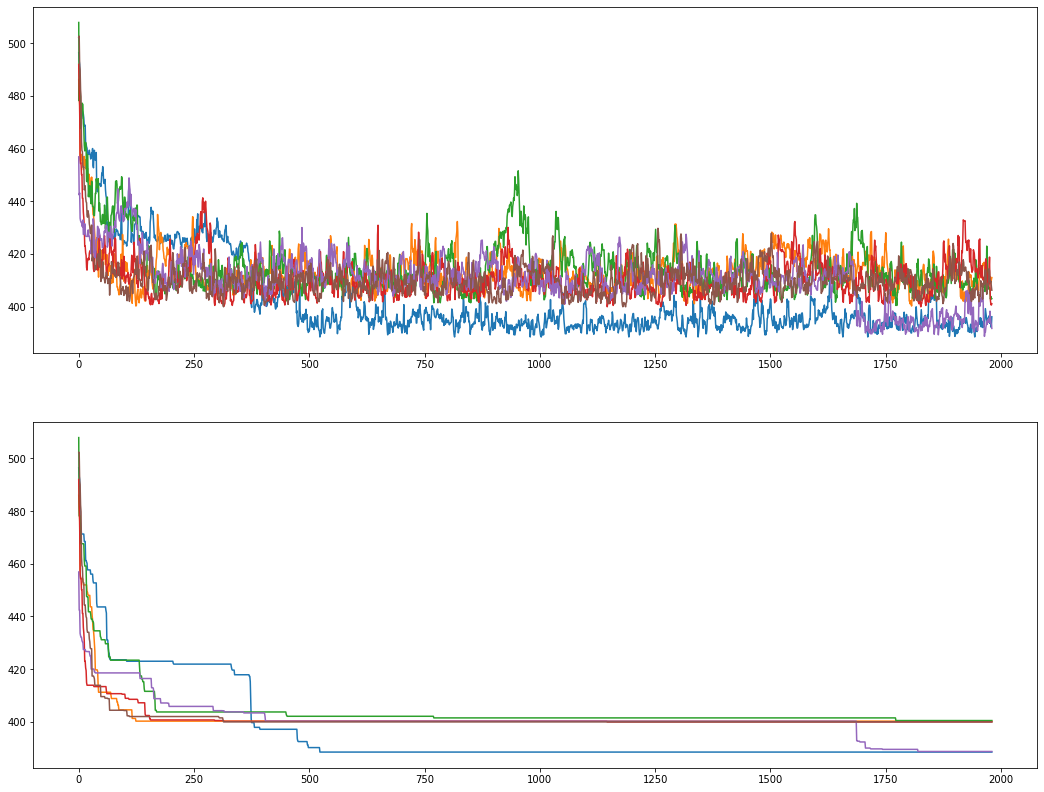

In [142]:
print(best_of_all)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 14))
for c, b in zip(costs_history, best_costs_history):
    ax1.plot(c[20:])
    ax2.plot(b[20:])
plt.show()

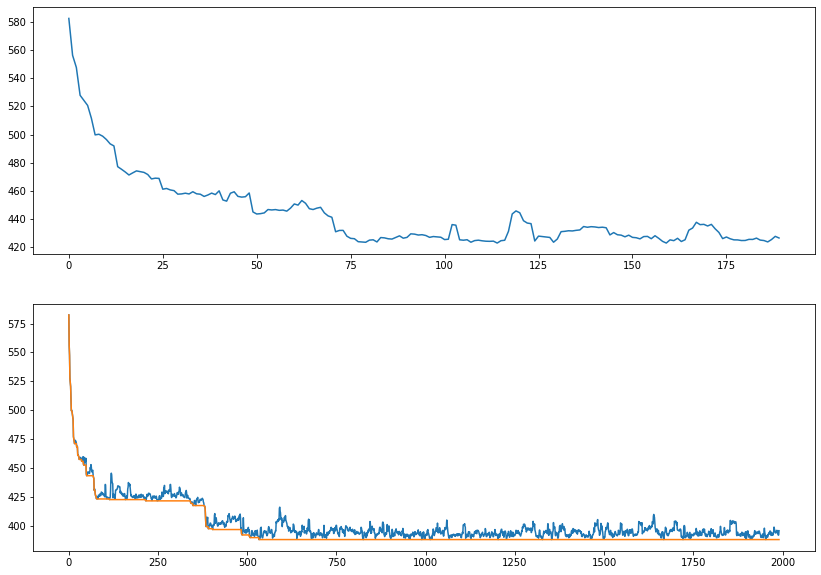

In [143]:
# print(ts3.generate_random_solution2())
# sol = ts3.generate_random_solution2()
# ts3.best_candidate = sol
# print(ts3.find_neighborhood_ids())

# Need for figure outside jupyter
# %matplotlib qt
# %matplotlib inline
# %matplotlib notebook
plt.figure(figsize=(14,10))
plt.subplot(211)
plt.plot(best_TS.costs[10:200])
plt.subplot(212)
plt.plot(best_TS.costs[10:])
plt.plot(best_TS.best_costs[10:])

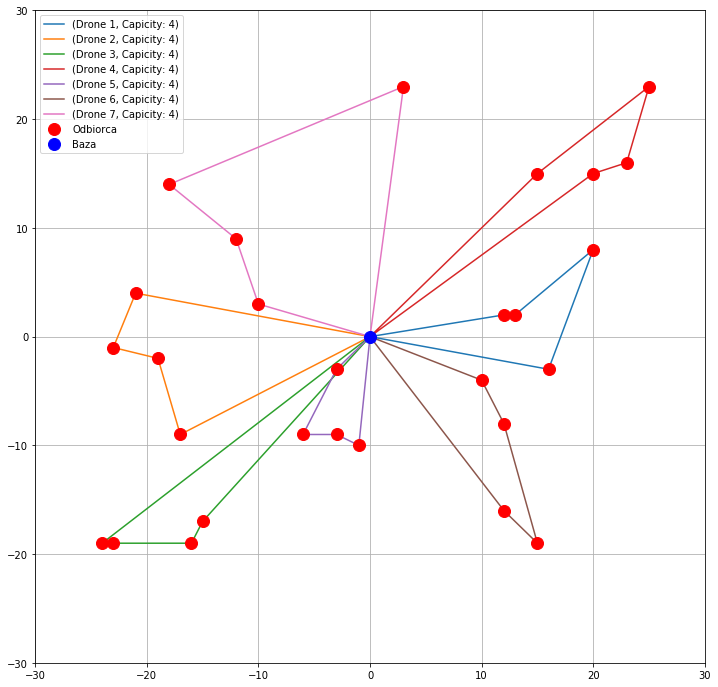

In [144]:
vis3 = WithVisualisation(best_TS)
vis3.plot_figure()
vis3.plot_solution()

In [362]:
np.set_printoptions(threshold=np.inf)
# ts3.distance_matrix

In [363]:
# best =\
# {0: [0, 22, 18, 19, 24], 1: [0, 11, 28, 20, 17], 2: [0, 12, 6, 5, 1], 3: [0, 7, 9, 14, 26], 4: [0, 2, 27, 3, 10], 5: [0, 8, 13, 21, 25], 6: [0, 15, 16, 4, 23]}
# best_path = {}
# for d in ts3.drones:
#     best_path[d] = [ts3.clients[v-1] for v in best[d.id-1] if v != 0]
#     best_path[d].insert(0, Client(0,0,0))
#     best_path[d].append(Client(0,0,0))

# ts3._best = best_path

In [364]:
# vis3 = WithVisualisation(ts3)
# vis3.plot_figure()
# vis3.plot_solution()